In [1]:
import pandas as pd
import numpy as np

Panel = pd.read_csv("Panel17.csv")
countries = set(Panel['iso'])

In [2]:
set(Panel['iso'])

{'AUS',
 'CAN',
 'CHE',
 'DEU',
 'DNK',
 'ESP',
 'FRA',
 'GBR',
 'ITA',
 'JPN',
 'NLD',
 'NOR',
 'SWE',
 'USA'}

In [3]:
DF_list= list()

newPanel = Panel[['iso','cpi', 'loans1','crisisST']]

countries = set(newPanel['iso'])

features = pd.get_dummies(newPanel['iso'])

newPanel = pd.concat([newPanel,features], axis=1)

for c in countries:
    temp = newPanel[newPanel['iso']==c]
    #temp = temp.dropna()
    DF_list.append(temp)

In [4]:
import numpy as np

DF_list2 = list()
xdata = pd.DataFrame()
ydata = pd.DataFrame()

var_lists = ['cpi', 'loans1']

new_var_lists = ['cpigrowth', 'creditgrowth']

#CreditGrowthReal = CreditGrowth - CPIGrowth;

for df in DF_list:
    df = df.dropna()
    df = df.reset_index()
    
    for v, nv in zip(var_lists, new_var_lists):
        f = np.diff(np.log(df[v]))
        lrf = pd.DataFrame({nv: f})
        df = pd.concat([df,lrf], axis=1)
    
    realg = df['creditgrowth'] - df['cpigrowth']
    
    X = pd.DataFrame()
    
    x = range(1,6)
    for lags in x:
        namevar = 'lagrealg' + str(lags)
        lrg = pd.DataFrame({namevar: realg })
        df = pd.concat([df,lrg], axis=1)
        df[namevar] = df[namevar].shift(lags)
        X = pd.concat([X,df[namevar]], axis=1)
        
    X = pd.concat([X,df['crisisST']], axis=1)
    df = df.dropna()
    DF_list2.append(df)
    
    for c in countries:
        X = pd.concat([X,df[c]], axis=1)
    
    X = X.dropna()
    
    xdata = xdata.append(X, ignore_index=True)


/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_20062/3082594986.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xdata = xdata.append(X, ignore_index=True)
/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_20062/3082594986.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xdata = xdata.append(X, ignore_index=True)
/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_20062/3082594986.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xdata = xdata.append(X, ignore_index=True)
/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_20062/3082594986.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

In [5]:
ydata = xdata['crisisST']
xdata = xdata.drop(['crisisST'], axis=1)

In [38]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn import neighbors, datasets
from sklearn import svm

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(xdata, ydata, test_size = 0.4, random_state = 42)

train_labels =np.array(train_labels)
train_features =np.array(train_features)
test_labels =np.array(test_labels)
test_features =np.array(test_features)

# Logistic Regression 
logreg_clf = LogisticRegression(C=1e5)
logreg_clf.fit(train_features, train_labels)

# Random Forest
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Train the model on training data
rf_clf.fit(train_features, train_labels)

# K-Nearest Neighbors 
n_neighbors = 3 
knn_clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
knn_clf.fit(train_features, train_labels)

# Support Vector Machine
svm_clf = svm.SVC(probability=True)
svm_clf.fit(train_features, train_labels)

# Multi-layer Perceptron
mlp_clf = MLPClassifier(random_state=1, max_iter=1000,hidden_layer_sizes = (10,10,10))
mlp_clf.fit(train_features, train_labels)



MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=1)

In [39]:
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.model_selection import cross_val_score

logreg_predictions = logreg_clf.predict(test_features)
rf_predictions = rf_clf.predict(test_features)
knn_predictions = knn_clf.predict(test_features)
svm_predictions = svm_clf.predict(test_features)
mlp_predictions = mlp_clf.predict(test_features)


# Calculate the absolute errors
logreg_errors = abs(logreg_predictions - test_labels)
rf_errors = abs(rf_predictions - test_labels)
knn_errors = abs(knn_predictions - test_labels)
svm_errors = abs(svm_predictions - test_labels)
mlp_errors = abs(mlp_predictions - test_labels)


# Print out the mean absolute error (mae)
print('Logistic Regression Mean Absolute Error:', round(np.mean(logreg_errors), 2))
print('RF Mean Absolute Error:', round(np.mean(rf_errors), 2))
print('KNN Mean Absolute Error:', round(np.mean(knn_errors), 2))
print('SVM Mean Absolute Error:', round(np.mean(svm_errors), 2))
print('MLP Mean Absolute Error:', round(np.mean(mlp_errors), 2))


clf_thres = 0.1
logreg_conf_mat = confusion_matrix(test_labels, np.heaviside(logreg_predictions-clf_thres,0) )
rf_conf_mat = confusion_matrix(test_labels, np.heaviside(rf_predictions-clf_thres,0) )
knn_conf_mat = confusion_matrix(test_labels, np.heaviside(knn_predictions-clf_thres,0) )
svm_conf_mat = confusion_matrix(test_labels, np.heaviside(svm_predictions-clf_thres,0) )
mlp_conf_mat = confusion_matrix(test_labels, np.heaviside(mlp_predictions-clf_thres,0) )


print(logreg_conf_mat)
print(rf_conf_mat)
print(knn_conf_mat)
print(svm_conf_mat)
print(mlp_conf_mat)


print(roc_auc_score(test_labels, logreg_clf.predict_proba(test_features)[:,1]))
print(roc_auc_score(test_labels, rf_clf.predict_proba(test_features)[:,1]))
print(roc_auc_score(test_labels, knn_clf.predict_proba(test_features)[:,1]))
print(roc_auc_score(test_labels, svm_clf.predict_proba(test_features)[:,1]))
print(roc_auc_score(test_labels, mlp_clf.predict_proba(test_features)[:,1]))

Logistic Regression Mean Absolute Error: 0.03
RF Mean Absolute Error: 0.03
KNN Mean Absolute Error: 0.03
SVM Mean Absolute Error: 0.03
MLP Mean Absolute Error: 0.05
[[616   0]
 [ 19   0]]
[[616   0]
 [ 19   0]]
[[613   3]
 [ 19   0]]
[[616   0]
 [ 19   0]]
[[604  12]
 [ 17   2]]
0.6758373205741626
0.7380809979494191
0.6027426520847574
0.5334928229665071
0.5705741626794258


/Users/eirikbaekkelund/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


/Users/eirikbaekkelund/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/eirikbaekkelund/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/eirikbaekkelund/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Func

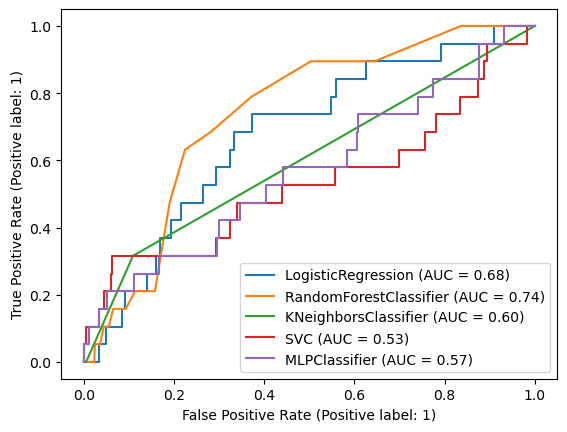

In [40]:
import matplotlib.pyplot as plt
from sklearn import metrics

roc_curves = metrics.plot_roc_curve(logreg_clf, test_features, test_labels) 
metrics.plot_roc_curve(rf_clf, test_features, test_labels, ax=roc_curves.ax_) 
metrics.plot_roc_curve(knn_clf, test_features, test_labels, ax=roc_curves.ax_) 
metrics.plot_roc_curve(svm_clf, test_features, test_labels, ax=roc_curves.ax_) 
metrics.plot_roc_curve(mlp_clf, test_features, test_labels, ax=roc_curves.ax_) 

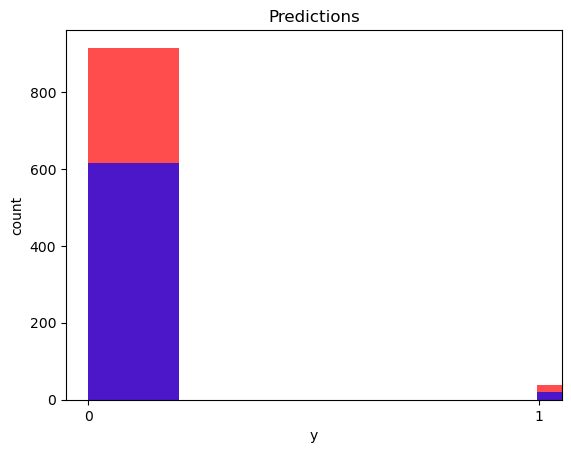

In [41]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.hist(train_labels, width=0.2, color='r',alpha=0.7, align='mid', bins=200)
plt.hist(test_labels, width=0.2, color='b',alpha=0.7, align='mid', bins=200)

plt.title('Predictions')
plt.xlabel('y')
plt.xticks([0,1])
plt.ylabel('count')
plt.show()

In [42]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn import neighbors, datasets
from sklearn import svm


# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(xdata, ydata, test_size = 0.6, random_state = 42)

train_labels =np.array(train_labels)
train_features =np.array(train_features)
test_labels =np.array(test_labels)
test_features =np.array(test_features)

crisisSteps, = np.nonzero(np.array(train_labels))
kB = 5

balancedSteps = np.concatenate((crisisSteps, np.random.randint(len(train_labels), size=kB*len(crisisSteps))))

print(len(balancedSteps))
train_labels_cr = train_labels[balancedSteps]
train_features_cr = train_features[balancedSteps]


# Logistic Regression 
logreg_clf = LogisticRegression(C=1e5)
logreg_clf.fit(train_features, train_labels)

# Random Forest
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Train the model on training data
rf_clf.fit(train_features, train_labels)

# K-Nearest Neighbors 
n_neighbors = 3 
knn_clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
knn_clf.fit(train_features, train_labels)

# Support Vector Machine
svm_clf = svm.SVC(probability=True)
svm_clf.fit(train_features, train_labels)

# Multi-layer Perceptron
mlp_clf = MLPClassifier(random_state=1, max_iter=1000,hidden_layer_sizes = (10,10,10))
mlp_clf.fit(train_features, train_labels)


144


MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=1)

/Users/eirikbaekkelund/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/eirikbaekkelund/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/eirikbaekkelund/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Func

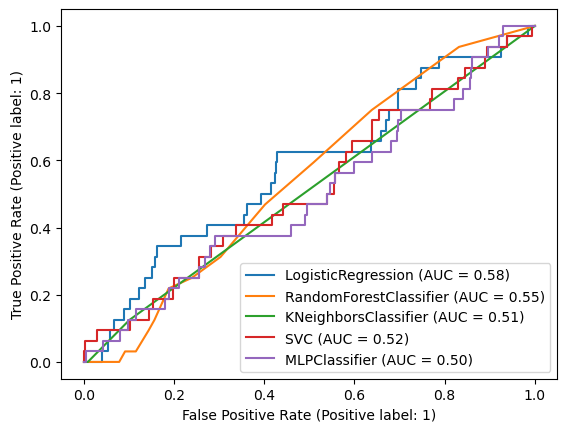

In [43]:
import matplotlib.pyplot as plt;
from sklearn import metrics;

roc_curves = metrics.plot_roc_curve(logreg_clf, test_features, test_labels);
metrics.plot_roc_curve(rf_clf, test_features, test_labels, ax=roc_curves.ax_);
metrics.plot_roc_curve(knn_clf, test_features, test_labels, ax=roc_curves.ax_);
metrics.plot_roc_curve(svm_clf, test_features, test_labels, ax=roc_curves.ax_);
metrics.plot_roc_curve(mlp_clf, test_features, test_labels, ax=roc_curves.ax_);